In [ ]:
# # Comment the following lines if you're not in colab:
# from google.colab import drive
# drive.mount('/content/drive')
# # If you're in colab, cd to your own working directory here:
# %cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-9

In [ ]:
# Python:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
# PyTorch:
import torch as tc
import torch.nn as nn
from torch.optim import AdamW
from torchsummary import summary
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
# RNG, Type, Device:
seed = 42
np.random.seed(seed)
tc.manual_seed(seed)
tc.set_default_dtype(tc.float32)
device = 'cuda' if tc.cuda.is_available() else 'cpu'
print(f"using {device}")

using cuda


# <u>Improved Diffusion Model</u>
We will make some small and easy adjustments to our previous model and see their impact. Scheduler remains the same:

In [ ]:
def get_schedules(beta_1, beta_t, timesteps):
    """
    Linear scheduler.
    Useful to pre-compute all the parameters (even fractions, square roots, etc).
    """
    beta_t = (beta_t - beta_1) * tc.arange(0, timesteps + 1, dtype=tc.float32) / timesteps + beta_1
    sqrt_beta_t = tc.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = tc.log(alpha_t)
    alphabar_t = tc.cumsum(log_alpha_t, dim=0).exp()
    sqrt_abar = tc.sqrt(alphabar_t)
    one_over_sqrt_a = 1 / tc.sqrt(alpha_t)
    sqrt_inv_abar = tc.sqrt(1 - alphabar_t)
    inv_abar_over_sqrt_inv_abar = (1 - alpha_t) / sqrt_inv_abar
    return {
        "alpha": alpha_t,
        "one_over_sqrt_a": one_over_sqrt_a,
        "sqrt_beta": sqrt_beta_t,
        "alphabar": alphabar_t,
        "sqrt_abar": sqrt_abar,
        "sqrt_inv_abar": sqrt_inv_abar,
        "inv_alpha_over_sqrt_inv_abar": inv_abar_over_sqrt_inv_abar,
    }

## <u>Channel Shuffling</u>
Introduced in https://arxiv.org/pdf/1707.01083.pdf

This operation does not change the size of the data in terms of width, height or batch size, only the **arrangement of the channels**, i.e., it shuffles them, so it is only a "structural" transformation in a sense. It can be best explained using an example.

**Example:** Assume batch size equal to one and an input tensor $T^{(\text{in})}$ initially shaped as $(C, H, W)$ where say $C = 8$, to which we apply this operation choosing groups say $G = 4$. Let $\mathbf{c_i}, \ i \in {1, 2, \dots, C}$ represent the channel vectors of this tensor. The transformation that will be applied to get the output tensor $T^{(\text{out})}$ is as follows:

\begin{equation}
T^{(\text{in})} =
    \begin{bmatrix}
        \mathbf{c_1} \\ \mathbf{c_2} \\ \mathbf{c_3} \\ \mathbf{c_4} \\
        \mathbf{c_5} \\ \mathbf{c_6} \\ \mathbf{c_7} \\ \mathbf{c_8}
    \end{bmatrix}
\rightarrow
    \begin{bmatrix}
        \text{Group 1: } \begin{bmatrix} \mathbf{c_1} \\ \mathbf{c_2} \end{bmatrix} \\
        \text{Group 2: } \begin{bmatrix} \mathbf{c_3} \\ \mathbf{c_4} \end{bmatrix} \\
        \text{Group 3: } \begin{bmatrix} \mathbf{c_5} \\ \mathbf{c_6} \end{bmatrix} \\
        \text{Group 4: } \begin{bmatrix} \mathbf{c_7} \\ \mathbf{c_8} \end{bmatrix}
    \end{bmatrix}
\rightarrow
    \begin{bmatrix}
        \text{New Channel 1: } \begin{bmatrix} \mathbf{c_1} \\ \mathbf{c_3} \\ \mathbf{c_5} \\ \mathbf{c_7} \end{bmatrix} \\
        \text{New Channel 2: } \begin{bmatrix} \mathbf{c_2} \\ \mathbf{c_4} \\ \mathbf{c_6} \\ \mathbf{c_8} \end{bmatrix}
    \end{bmatrix}
\rightarrow
    \begin{bmatrix}
        \mathbf{c_1} \\ \mathbf{c_3} \\ \mathbf{c_5} \\ \mathbf{c_7} \\
         \mathbf{c_8} \\ \mathbf{c_4} \\ \mathbf{c_6} \\ \mathbf{c_8}
    \end{bmatrix}
= T^{(\text{out})}
\end{equation}

Some of its benefits include:
+ It encourages the network to maintain performance consistency across different combinations of features, potentially increasing the robustness and generalization capability of the model.
+ Prevents the model from relying too heavily on specific channel-based patterns, ensuring that dependencies and information are shared more uniformly across the network. This can reduce overfitting, thus encouraging the development of more holistic and adaptable feature detectors.

PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.ChannelShuffle.html


In [ ]:

class ChannelShuffle(nn.Module):
    def __init__(self, groups):
        super().__init__()
        self.groups = groups

    def forward(self, x):
        n, c, h, w = x.shape
        x = x.view(n, self.groups, c//self.groups, h, w)         # group
        return x.transpose(1, 2).contiguous().view(n, -1, h, w)  # shuffle

## <u>Sigmoid Linear Unit (SiLU or Swish)</u>
We will use a different activation function than previously, first introduced in https://arxiv.org/pdf/1702.03118.pdf.

\begin{equation}
\text{SiLU}(x) = x\cdot \sigma(x), \ \text{where:} \\
\end{equation}
\begin{equation}
\sigma(x) = \frac{1}{1+e^{-x}}.
\end{equation}

![](fig/silu.png)
![](https://drive.google.com/uc?export=view&id=1lOGdywYax2-kJIcuKkw3EUQwZdW552s_)

Comparison with ReLU (and its variants):
+ Smoother and non-monotonic
+ Continuously differentiable everywhere (ReLU is not at zero)
+ Prevention of dead neurons (dying ReLU problem)
+ Larger operation range (allows also negatives)
+ Better gradient propagation (better avoids vanishing/exploding gradient issues)
+ More dynamic (since it is scaled by $x$)
+ Empirical performance (Google Brain)

# <u>U-Net Block Change</u>

+ Change from ReLU-types to a SiLU activation.

In [ ]:
class ConvBlock(nn.Module):
    """The elementary U-Net block."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=1, padding=1
            ),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),
            nn.SiLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

## <u>Encoder Changes</u>

+ Employ channel shuffling after every downsampling layer.
+ Use SiLU activations only instead of ReLU variants.

In [ ]:
class UnetDown(nn.Module):
    """The elementary encoder block."""
    def __init__(self, in_channels, out_channels, downscale=2):
        super(UnetDown, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(in_channels=in_channels, out_channels=out_channels),
            nn.MaxPool2d(kernel_size=downscale)
        )
    def forward(self, x):
        return self.model(x)

class Encoder(nn.Module):
    def __init__(self, n_features):
        super(Encoder, self).__init__()
        self.initial_features = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=n_features,
                kernel_size=3, stride=1, padding=1
            ),
            nn.GroupNorm(num_groups=8, num_channels=n_features),
            nn.SiLU(),
        )
        self.down1 = UnetDown(in_channels=n_features, out_channels=n_features, downscale=2)
        self.down2 = UnetDown(in_channels=n_features, out_channels=2*n_features, downscale=2)
        self.down3 = UnetDown(in_channels=2*n_features, out_channels=2*n_features, downscale=2)
        self.down4 = nn.Sequential(
            nn.AvgPool2d(kernel_size=3),
            nn.SiLU()
        )
        self.chan_shuffle = ChannelShuffle(groups=2)

    def forward(self, x):
        x_f = self.initial_features(x)
        d1 = self.chan_shuffle(self.down1(x_f))
        d2 = self.chan_shuffle(self.down2(d1))
        d3 = self.chan_shuffle(self.down3(d2))
        latent = self.down4(d3)
        return x_f, d1, d2, d3, latent

## <u>Decoder Changes</u>

+ Employ channel shuffling after every upsampling layer.
+ Use SiLU activations only instead of ReLU variants.

In [ ]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels, upscale=2, extra_dim=0):
        super(UnetUp, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=upscale, stride=upscale, output_padding=extra_dim
            ),
            nn.SiLU(),
            ConvBlock(in_channels=out_channels, out_channels=out_channels),
        )

    def forward(self, x, skip):
        x = tc.cat((x, skip), 1)
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, n_features):
        super(Decoder, self).__init__()
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=2*n_features, out_channels=2*n_features,
                kernel_size=3, stride=3
            ),
            nn.GroupNorm(num_groups=8, num_channels=2*n_features),
            nn.SiLU(),
        )
        self.up2 = UnetUp(
            in_channels=4*n_features, out_channels=2*n_features,
            upscale=2, extra_dim=1
        )
        self.up3 = UnetUp(
            in_channels=4*n_features, out_channels=n_features,
            upscale=2
        )
        self.up4 = UnetUp(
            in_channels=2*n_features, out_channels=n_features,
            upscale=2
        )
        self.out = nn.Conv2d(
            in_channels=2*n_features, out_channels=1,
            kernel_size=3, stride=1, padding=1
        )
        self.chan_shuffle = ChannelShuffle(groups=2)

    def forward(self, latent, d3, d2, d1, x_f):
        u1 = self.up1(latent)
        u2 = self.chan_shuffle(self.up2(u1, d3))
        u3 = self.chan_shuffle(self.up3(u2, d2))
        u4 = self.chan_shuffle(self.up4(u3, d1))
        return self.out(tc.cat([u4, x_f], dim=1))

## Time Embedding Change

+ Use SiLU activation instead of sine.

In [ ]:
# Time embedding layer
class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(TimeEmbedding, self).__init__()
        self.embedding_dim = embedding_dim
        self.lin1 = nn.Linear(in_features=1, out_features=embedding_dim//2, bias=False)
        self.lin2 = nn.Linear(in_features=embedding_dim//2, out_features=embedding_dim)
        self.act = nn.SiLU()

    def forward(self, ts):
        ts = ts.view(-1, 1)
        t_emb = self.act(self.lin1(ts))
        t_emb = self.lin2(t_emb)
        return t_emb.view(-1, self.embedding_dim, 1, 1)  # add dummy channels to sum with latent

# <u>Diffusion Model</u>

+ No additional change aside from the above.

In [ ]:
class DiffusionModel(nn.Module):
    def __init__(self, n_features=64):
        super(DiffusionModel, self).__init__()
        self.encoder = Encoder(n_features=n_features)
        self.decoder = Decoder(n_features=n_features)
        self.time_embedding_layer = TimeEmbedding(embedding_dim=2*n_features)

    def forward(self, x, t):
        # pass through encoder:
        x_f, d1, d2, d3, latent = self.encoder(x)
        # get time embedding:
        latent_t_emb = latent + self.time_embedding_layer(t)
        # intermediate decoder steps are not needed:
        return self.decoder(latent_t_emb, d3, d2, d1, x_f)

    def sample(self, n_samples, timesteps, sample_shape):
        # Initialize the noise sample:
        x_t = tc.randn(n_samples, *sample_shape).to(device)
        ones = tc.ones(n_samples).to(device)
        x_i = x_t
        for i in tqdm(range(timesteps, 0, -1)):
            z = tc.randn(n_samples, *sample_shape).to(device) if i > 1 else 0
            t = (i / timesteps) * ones
            eps = self.forward(x_i, t).clone().detach()
            v = schedules["one_over_sqrt_a"][i] * (x_i - eps * schedules["inv_alpha_over_sqrt_inv_abar"][i])
            x_i = v + schedules["sqrt_beta"][i] * z
        return x_i.cpu().detach().numpy().reshape(n_samples, *sample_shape).squeeze(1)

### <u>Hyperparameters & Dataset Changes</u>

+ Batch size increased to $128$ from $64$.
+ Learning rate increased to $10^{-3}$ from $10^{-5}$.

In [ ]:
length, height = 28, 28  # MNIST is 28*28 images
input_shape = (1, height, length)
no_features = 128
epochs = 100
batch_size = 128
lr = 1e-3
n_T = 1000
betas = [1e-4, 0.02]

transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
dataset = MNIST("./data", train=True, download=True, transform=transform,)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

### <u>Model & Noise Schedule Change</u>

+ AdamW optimizer instead of Adam

In [ ]:
model = DiffusionModel(n_features=no_features).to(device)
loss_fn = nn.MSELoss()
optim = AdamW(params=model.parameters(), lr=lr)
_ = summary(model=model, input_data=[tc.zeros(size=(batch_size, 1, 28, 28)), tc.zeros(batch_size)])

schedules = get_schedules(betas[0], betas[1], n_T)
# add all tensors on device:
schedules = {key: val.to(device) for key, val in schedules.items()}

Layer (type:depth-idx)                        Output Shape              Param #
├─Encoder: 1-1                                [-1, 128, 28, 28]         --
|    └─Sequential: 2-1                        [-1, 128, 28, 28]         --
|    |    └─Conv2d: 3-1                       [-1, 128, 28, 28]         1,280
|    |    └─GroupNorm: 3-2                    [-1, 128, 28, 28]         256
|    |    └─SiLU: 3-3                         [-1, 128, 28, 28]         --
|    └─UnetDown: 2-2                          [-1, 128, 14, 14]         --
|    |    └─Sequential: 3-4                   [-1, 128, 14, 14]         147,840
|    └─ChannelShuffle: 2-3                    [-1, 128, 14, 14]         --
|    └─UnetDown: 2-4                          [-1, 256, 7, 7]           --
|    |    └─Sequential: 3-5                   [-1, 256, 7, 7]           295,680
|    └─ChannelShuffle: 2-5                    [-1, 256, 7, 7]           --
|    └─UnetDown: 2-6                          [-1, 256, 3, 3]           --
|    |

### <u>Generation/Sampling</u>

+ No changes.

100%|██████████| 1000/1000 [00:05<00:00, 181.28it/s]


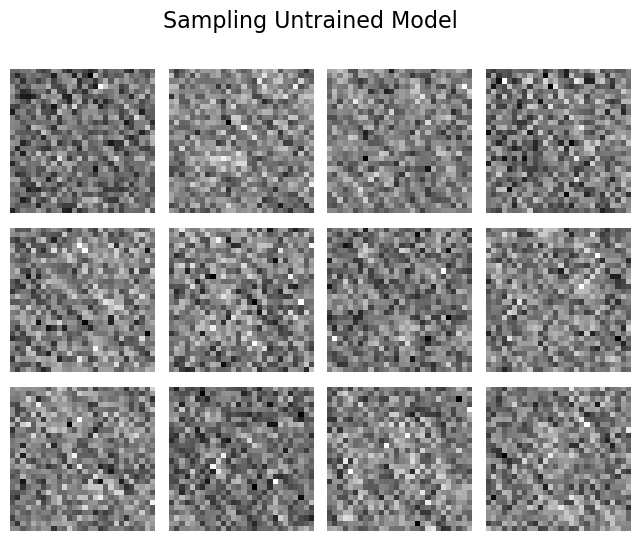

In [ ]:
def sample(n_samples=12, sample_shape=(1, 28, 28), timesteps=1000, title="None"):
    x_hat = model.sample(n_samples=n_samples, sample_shape=sample_shape, timesteps=timesteps)
    n_rows = (n_samples + 3) // 4
    fig, axs = plt.subplots(
        nrows=n_rows, ncols=4, figsize=(8, 2 * n_rows),
        subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
    )
    for i, axis in enumerate(axs.flat[:n_samples]):
        axis.imshow(x_hat[i], cmap='binary')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close()

sample(title="Sampling Untrained Model")

# <u>Training Loop</u>

+ No changes.

Epoch 1 : 


Moving Average Loss: 0.0543: 100%|██████████| 469/469 [00:46<00:00, 10.09it/s]


Epoch 2 : 


Moving Average Loss: 0.0359: 100%|██████████| 469/469 [00:46<00:00, 10.18it/s]


Epoch 3 : 


Moving Average Loss: 0.0374: 100%|██████████| 469/469 [00:45<00:00, 10.20it/s]


Epoch 4 : 


Moving Average Loss: 0.0324: 100%|██████████| 469/469 [00:46<00:00, 10.13it/s]


Epoch 5 : 


Moving Average Loss: 0.0325: 100%|██████████| 469/469 [00:46<00:00, 10.14it/s]


Epoch 6 : 


Moving Average Loss: 0.0315: 100%|██████████| 469/469 [00:45<00:00, 10.29it/s]


Epoch 7 : 


Moving Average Loss: 0.0291: 100%|██████████| 469/469 [00:45<00:00, 10.27it/s]


Epoch 8 : 


Moving Average Loss: 0.0287: 100%|██████████| 469/469 [00:45<00:00, 10.26it/s]


Epoch 9 : 


Moving Average Loss: 0.0322: 100%|██████████| 469/469 [00:45<00:00, 10.38it/s]


Epoch 10 : 


100%|██████████| 1000/1000 [00:04<00:00, 213.32it/s]


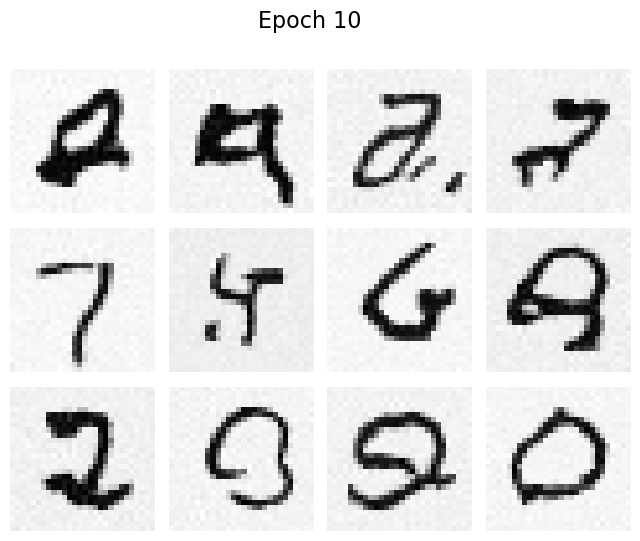

Epoch 11 : 


Moving Average Loss: 0.0261: 100%|██████████| 469/469 [00:44<00:00, 10.45it/s]


Epoch 12 : 


Moving Average Loss: 0.0263: 100%|██████████| 469/469 [00:45<00:00, 10.24it/s]


Epoch 13 : 


Moving Average Loss: 0.0259: 100%|██████████| 469/469 [00:45<00:00, 10.34it/s]


Epoch 14 : 


Moving Average Loss: 0.0268: 100%|██████████| 469/469 [00:45<00:00, 10.36it/s]


Epoch 15 : 


Moving Average Loss: 0.0271: 100%|██████████| 469/469 [00:44<00:00, 10.47it/s]


Epoch 16 : 


Moving Average Loss: 0.0244: 100%|██████████| 469/469 [00:45<00:00, 10.34it/s]


Epoch 17 : 


Moving Average Loss: 0.0249: 100%|██████████| 469/469 [00:45<00:00, 10.26it/s]


Epoch 18 : 


Moving Average Loss: 0.0271: 100%|██████████| 469/469 [00:45<00:00, 10.22it/s]


Epoch 19 : 


Moving Average Loss: 0.0244: 100%|██████████| 469/469 [00:45<00:00, 10.28it/s]


Epoch 20 : 


100%|██████████| 1000/1000 [00:04<00:00, 213.81it/s]


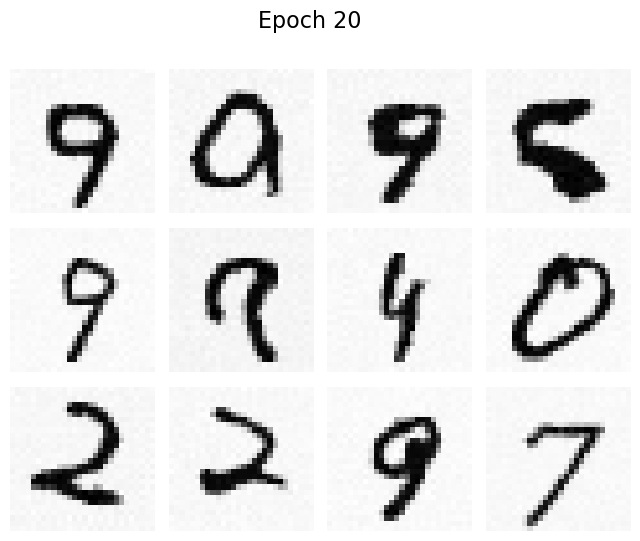

Epoch 21 : 


Moving Average Loss: 0.0236: 100%|██████████| 469/469 [00:44<00:00, 10.44it/s]


Epoch 22 : 


Moving Average Loss: 0.0232: 100%|██████████| 469/469 [00:44<00:00, 10.43it/s]


Epoch 23 : 


Moving Average Loss: 0.0255: 100%|██████████| 469/469 [00:44<00:00, 10.43it/s]


Epoch 24 : 


Moving Average Loss: 0.0248: 100%|██████████| 469/469 [00:44<00:00, 10.44it/s]


Epoch 25 : 


Moving Average Loss: 0.0257: 100%|██████████| 469/469 [00:45<00:00, 10.34it/s]


Epoch 26 : 


Moving Average Loss: 0.0228: 100%|██████████| 469/469 [00:44<00:00, 10.43it/s]


Epoch 27 : 


Moving Average Loss: 0.0231: 100%|██████████| 469/469 [00:44<00:00, 10.44it/s]


Epoch 28 : 


Moving Average Loss: 0.0238: 100%|██████████| 469/469 [00:45<00:00, 10.42it/s]


Epoch 29 : 


Moving Average Loss: 0.0241: 100%|██████████| 469/469 [00:45<00:00, 10.39it/s]


Epoch 30 : 


100%|██████████| 1000/1000 [00:04<00:00, 207.11it/s]


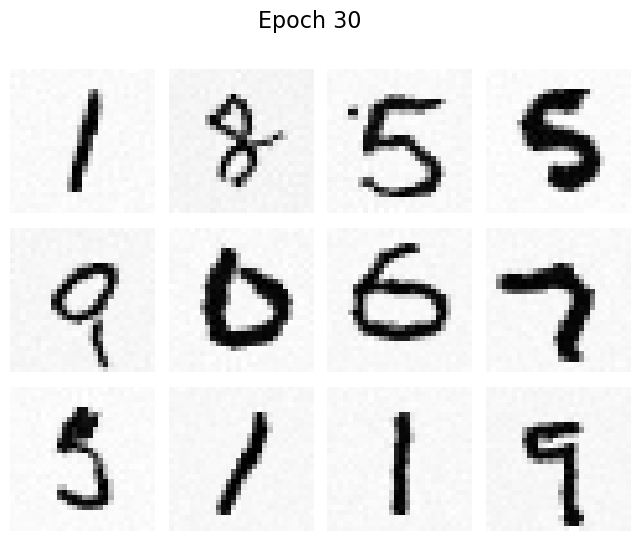

Epoch 31 : 


Moving Average Loss: 0.0250: 100%|██████████| 469/469 [00:47<00:00,  9.96it/s]


Epoch 32 : 


Moving Average Loss: 0.0249: 100%|██████████| 469/469 [00:47<00:00,  9.97it/s]


Epoch 33 : 


Moving Average Loss: 0.0254: 100%|██████████| 469/469 [00:46<00:00, 10.14it/s]


Epoch 34 : 


Moving Average Loss: 0.0244: 100%|██████████| 469/469 [00:47<00:00,  9.95it/s]


Epoch 35 : 


Moving Average Loss: 0.0222: 100%|██████████| 469/469 [00:47<00:00,  9.89it/s]


Epoch 36 : 


Moving Average Loss: 0.0222: 100%|██████████| 469/469 [00:47<00:00,  9.94it/s]


Epoch 37 : 


Moving Average Loss: 0.0215: 100%|██████████| 469/469 [00:45<00:00, 10.28it/s]


Epoch 38 : 


Moving Average Loss: 0.0219: 100%|██████████| 469/469 [00:45<00:00, 10.28it/s]


Epoch 39 : 


Moving Average Loss: 0.0227: 100%|██████████| 469/469 [00:45<00:00, 10.24it/s]


Epoch 40 : 


100%|██████████| 1000/1000 [00:04<00:00, 210.22it/s]


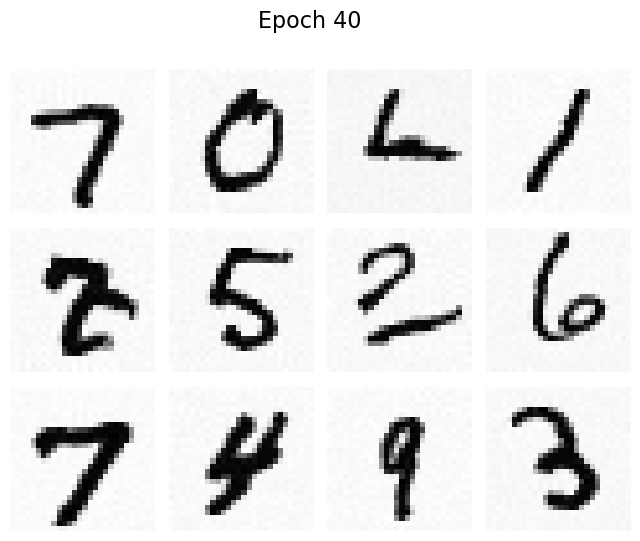

Epoch 41 : 


Moving Average Loss: 0.0246: 100%|██████████| 469/469 [00:45<00:00, 10.26it/s]


Epoch 42 : 


Moving Average Loss: 0.0251: 100%|██████████| 469/469 [00:46<00:00, 10.13it/s]


Epoch 43 : 


Moving Average Loss: 0.0247: 100%|██████████| 469/469 [00:45<00:00, 10.20it/s]


Epoch 44 : 


Moving Average Loss: 0.0234: 100%|██████████| 469/469 [00:45<00:00, 10.24it/s]


Epoch 45 : 


Moving Average Loss: 0.0240: 100%|██████████| 469/469 [00:45<00:00, 10.27it/s]


Epoch 46 : 


Moving Average Loss: 0.0223: 100%|██████████| 469/469 [00:46<00:00, 10.04it/s]


Epoch 47 : 


Moving Average Loss: 0.0220: 100%|██████████| 469/469 [00:45<00:00, 10.26it/s]


Epoch 48 : 


Moving Average Loss: 0.0241: 100%|██████████| 469/469 [00:46<00:00, 10.19it/s]


Epoch 49 : 


Moving Average Loss: 0.0235: 100%|██████████| 469/469 [00:46<00:00, 10.11it/s]


Epoch 50 : 


100%|██████████| 1000/1000 [00:04<00:00, 202.53it/s]


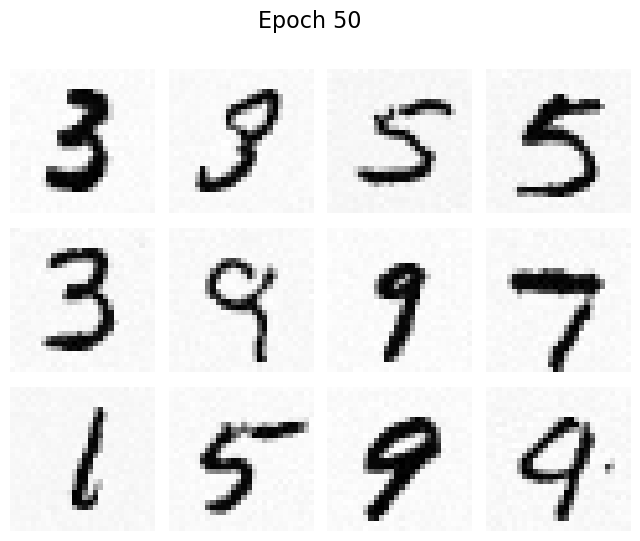

Epoch 51 : 


Moving Average Loss: 0.0235: 100%|██████████| 469/469 [00:45<00:00, 10.22it/s]


Epoch 52 : 


Moving Average Loss: 0.0235: 100%|██████████| 469/469 [00:45<00:00, 10.27it/s]


Epoch 53 : 


Moving Average Loss: 0.0231: 100%|██████████| 469/469 [00:45<00:00, 10.24it/s]


Epoch 54 : 


Moving Average Loss: 0.0249: 100%|██████████| 469/469 [00:45<00:00, 10.29it/s]


Epoch 55 : 


Moving Average Loss: 0.0229: 100%|██████████| 469/469 [00:45<00:00, 10.27it/s]


Epoch 56 : 


Moving Average Loss: 0.0216: 100%|██████████| 469/469 [00:46<00:00, 10.15it/s]


Epoch 57 : 


Moving Average Loss: 0.0229: 100%|██████████| 469/469 [00:47<00:00,  9.80it/s]


Epoch 58 : 


Moving Average Loss: 0.0223: 100%|██████████| 469/469 [00:46<00:00,  9.98it/s]


Epoch 59 : 


Moving Average Loss: 0.0226: 100%|██████████| 469/469 [00:46<00:00, 10.05it/s]


Epoch 60 : 


100%|██████████| 1000/1000 [00:04<00:00, 202.74it/s]


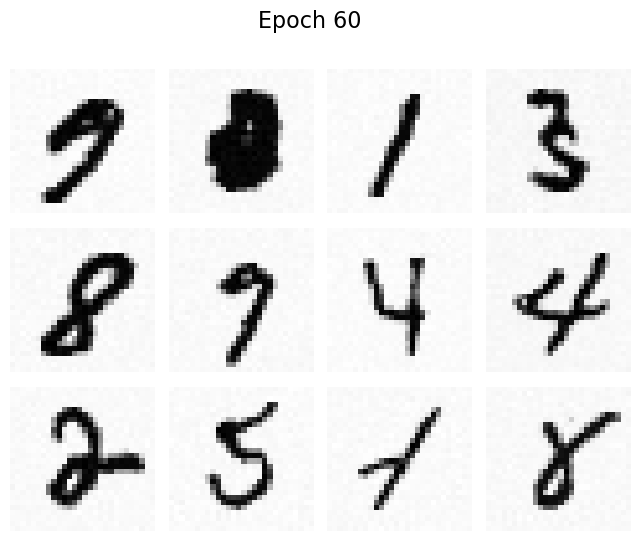

Epoch 61 : 


Moving Average Loss: 0.0226: 100%|██████████| 469/469 [00:48<00:00,  9.77it/s]


Epoch 62 : 


Moving Average Loss: 0.0215: 100%|██████████| 469/469 [00:45<00:00, 10.26it/s]


Epoch 63 : 


Moving Average Loss: 0.0220: 100%|██████████| 469/469 [00:45<00:00, 10.25it/s]


Epoch 64 : 


Moving Average Loss: 0.0233: 100%|██████████| 469/469 [00:45<00:00, 10.23it/s]


Epoch 65 : 


Moving Average Loss: 0.0214: 100%|██████████| 469/469 [00:45<00:00, 10.25it/s]


Epoch 66 : 


Moving Average Loss: 0.0233: 100%|██████████| 469/469 [00:46<00:00, 10.04it/s]


Epoch 67 : 


Moving Average Loss: 0.0234: 100%|██████████| 469/469 [00:46<00:00, 10.06it/s]


Epoch 68 : 


Moving Average Loss: 0.0223: 100%|██████████| 469/469 [00:46<00:00, 10.05it/s]


Epoch 69 : 


Moving Average Loss: 0.0221: 100%|██████████| 469/469 [00:46<00:00, 10.01it/s]


Epoch 70 : 


100%|██████████| 1000/1000 [00:04<00:00, 203.85it/s]


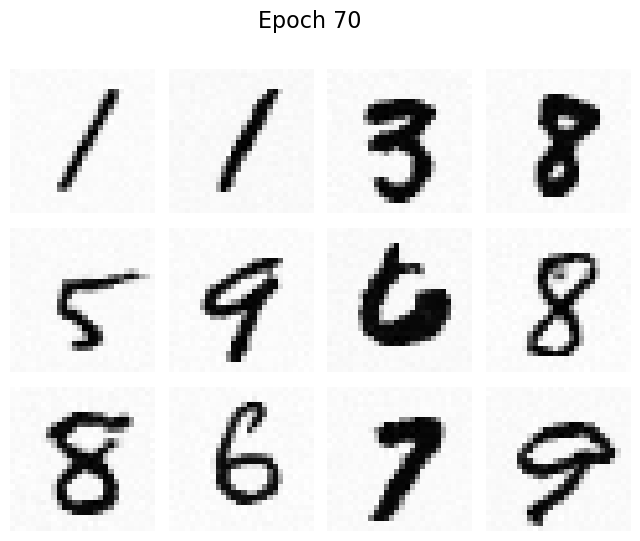

Epoch 71 : 


Moving Average Loss: 0.0236: 100%|██████████| 469/469 [00:46<00:00, 10.02it/s]


Epoch 72 : 


Moving Average Loss: 0.0221: 100%|██████████| 469/469 [00:46<00:00, 10.00it/s]


Epoch 73 : 


Moving Average Loss: 0.0217: 100%|██████████| 469/469 [00:47<00:00,  9.84it/s]


Epoch 74 : 


Moving Average Loss: 0.0225: 100%|██████████| 469/469 [00:46<00:00, 10.19it/s]


Epoch 75 : 


Moving Average Loss: 0.0220: 100%|██████████| 469/469 [00:46<00:00, 10.10it/s]


Epoch 76 : 


Moving Average Loss: 0.0229: 100%|██████████| 469/469 [00:46<00:00, 10.05it/s]


Epoch 77 : 


Moving Average Loss: 0.0235: 100%|██████████| 469/469 [00:46<00:00, 10.01it/s]


Epoch 78 : 


Moving Average Loss: 0.0227: 100%|██████████| 469/469 [00:46<00:00, 10.13it/s]


Epoch 79 : 


Moving Average Loss: 0.0241: 100%|██████████| 469/469 [00:45<00:00, 10.22it/s]


Epoch 80 : 


100%|██████████| 1000/1000 [00:04<00:00, 213.08it/s]


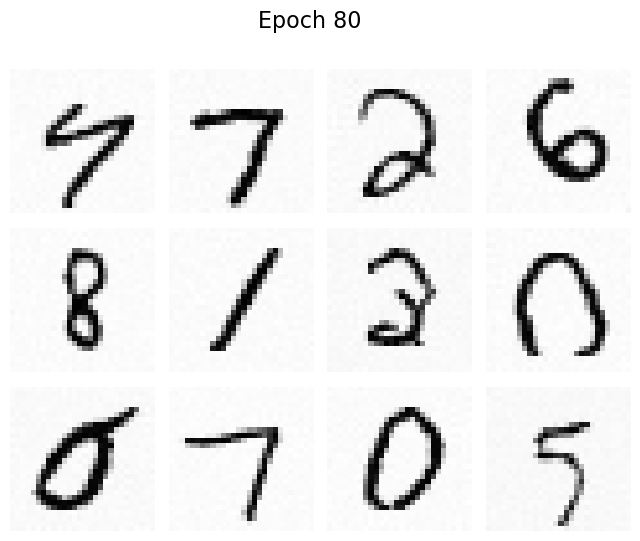

Epoch 81 : 


Moving Average Loss: 0.0232: 100%|██████████| 469/469 [00:45<00:00, 10.27it/s]


Epoch 82 : 


Moving Average Loss: 0.0221: 100%|██████████| 469/469 [00:45<00:00, 10.27it/s]


Epoch 83 : 


Moving Average Loss: 0.0220: 100%|██████████| 469/469 [00:46<00:00, 10.16it/s]


Epoch 84 : 


Moving Average Loss: 0.0244: 100%|██████████| 469/469 [00:46<00:00, 10.03it/s]


Epoch 85 : 


Moving Average Loss: 0.0225: 100%|██████████| 469/469 [00:46<00:00, 10.15it/s]


Epoch 86 : 


Moving Average Loss: 0.0216: 100%|██████████| 469/469 [00:46<00:00, 10.13it/s]


Epoch 87 : 


Moving Average Loss: 0.0241: 100%|██████████| 469/469 [00:46<00:00, 10.09it/s]


Epoch 88 : 


Moving Average Loss: 0.0208: 100%|██████████| 469/469 [00:46<00:00, 10.08it/s]


Epoch 89 : 


Moving Average Loss: 0.0217: 100%|██████████| 469/469 [00:46<00:00, 10.09it/s]


Epoch 90 : 


100%|██████████| 1000/1000 [00:04<00:00, 204.85it/s]


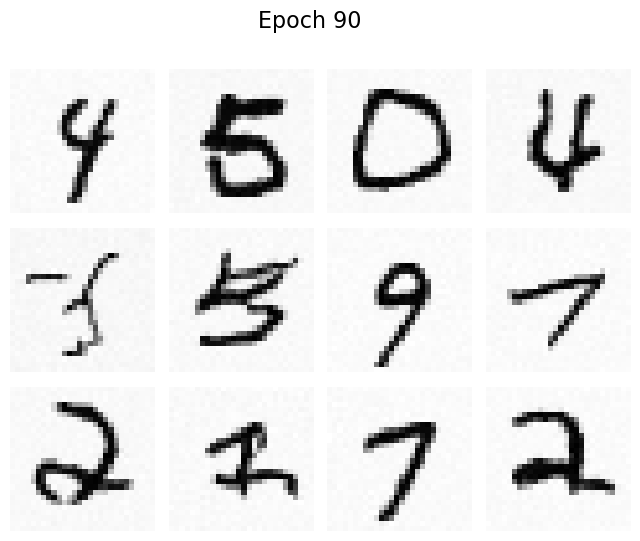

Epoch 91 : 


Moving Average Loss: 0.0228: 100%|██████████| 469/469 [00:47<00:00,  9.95it/s]


Epoch 92 : 


Moving Average Loss: 0.0228: 100%|██████████| 469/469 [00:51<00:00,  9.13it/s]


Epoch 93 : 


Moving Average Loss: 0.0234: 100%|██████████| 469/469 [00:47<00:00,  9.91it/s]


Epoch 94 : 


Moving Average Loss: 0.0216: 100%|██████████| 469/469 [00:46<00:00, 10.01it/s]


Epoch 95 : 


Moving Average Loss: 0.0230: 100%|██████████| 469/469 [00:46<00:00, 10.02it/s]


Epoch 96 : 


Moving Average Loss: 0.0221: 100%|██████████| 469/469 [00:46<00:00, 10.03it/s]


Epoch 97 : 


Moving Average Loss: 0.0230: 100%|██████████| 469/469 [00:46<00:00, 10.01it/s]


Epoch 98 : 


Moving Average Loss: 0.0214: 100%|██████████| 469/469 [00:46<00:00, 10.03it/s]


Epoch 99 : 


Moving Average Loss: 0.0215: 100%|██████████| 469/469 [00:47<00:00,  9.98it/s]


Epoch 100 : 


100%|██████████| 1000/1000 [00:04<00:00, 206.70it/s]


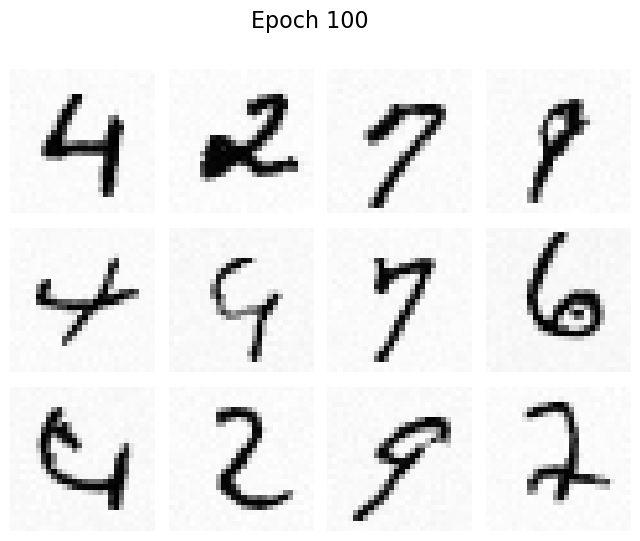

In [ ]:
def train_loop():
    losses = []
    print_every = 10
    for epoch in range(epochs):
        print(f"Epoch {epoch+1} : ")
        model.train()
        pbar = tqdm(dataloader)
        for x, _ in pbar:
            x = x.to(device).view(-1, 1, 28, 28)
            timesteps = tc.randint(1, n_T + 1, (x.shape[0],)).to(device)
            eps = tc.randn_like(x)
            optim.zero_grad()
            x_t = schedules["sqrt_abar"][timesteps, None, None, None] * x + \
                  schedules["sqrt_inv_abar"][timesteps, None, None, None] * eps
            t = timesteps/n_T
            eps_hat = model(x_t, t)
            loss = loss_fn(eps_hat, eps)
            loss.backward()
            losses.append(loss.item())
            avg_loss = np.asarray(losses)[-10:].mean()
            pbar.set_description(f"Moving Average Loss: {avg_loss:.4f}")
            optim.step()
        if (epoch + 1) % print_every == 0:
            with tc.no_grad():
                model.eval()
                sample(title=f"Epoch {epoch+1}")
                model.train()
    return losses

train_losses = train_loop()

### <u>Plot Loss</u>

+ No changes.

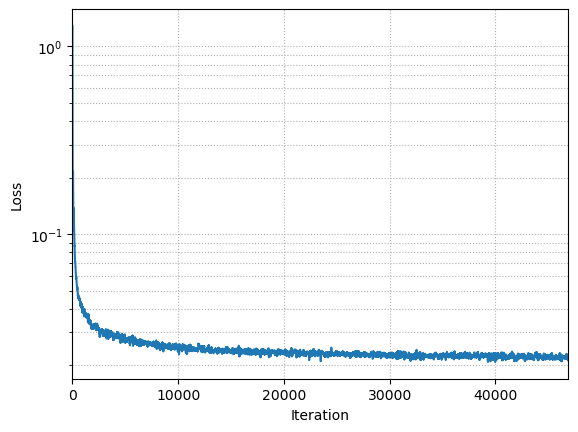

In [ ]:
smooth_losses = savgol_filter(x=train_losses, window_length=201, polyorder=7)
plt.figure()
plt.semilogy(smooth_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xlim([0, len(train_losses)])
plt.grid(linestyle=':', which='both')
plt.show()
plt.close()

### <u>Bonus: Extra Improvements</u>

The model's generations improved, and its training is more stable, but it has approximately 3.5M trainable parameters which are a lot for a simple dataset like MNIST, and its digit generation can still be further improved:

+ Introduce residual layers within the architecture.
+ Increase the depth of the architecture.
+ Implement a faster diffusion process (discussed in our first notebook).

If done correctly, this can reduce the parameters to approximately 1M and produce much better digits quality-wise:
https://github.com/bot66/MNISTDiffusion